In [19]:
import math
from typing import Union, Iterable
import itertools
import numpy
import copy

from build123d import *

if "__file__" in globals() and __file__.endswith(".py"):
    print("Running headless")

    def show(*_, **_____):
        pass

else:
    import jupyter_cadquery as jcq
    from jupyter_cadquery.replay import show as _show

    jcq.set_defaults(
        control="orbit",
        axes=True,
        axes0=True,
        grid=(True, False, False),
        glass=True,
        theme="browser",
    )

    def show(*cad_objs, names=[], colors=[], render_joints:bool=True, **kwargs):
        _names = []
        _objs = []
        _colors = []
        for cad_obj in cad_objs:
            _names.append(names.pop(0) if names else None)
            _colors.append(colors.pop(0) if colors else None)
            _objs.append(cad_obj)
            if render_joints and hasattr(cad_obj, "joints") and cad_obj.joints:
                for name, joint in cad_obj.joints.items():
                    _names.append(f"joint_{name}")
                    _colors.append(None)
                    _objs.append(joint.symbol)
        _show(*_objs, names=_names, colors=_colors, **kwargs)



def export(part: Part, name: str):
    part.export_step(f"out/{name}.step")

In [2]:
%%html
<style>
   /* Fix widget background color in VS Code */
   .cell-output-ipywidget-background {
      background-color: transparent !important;
   }
</style>

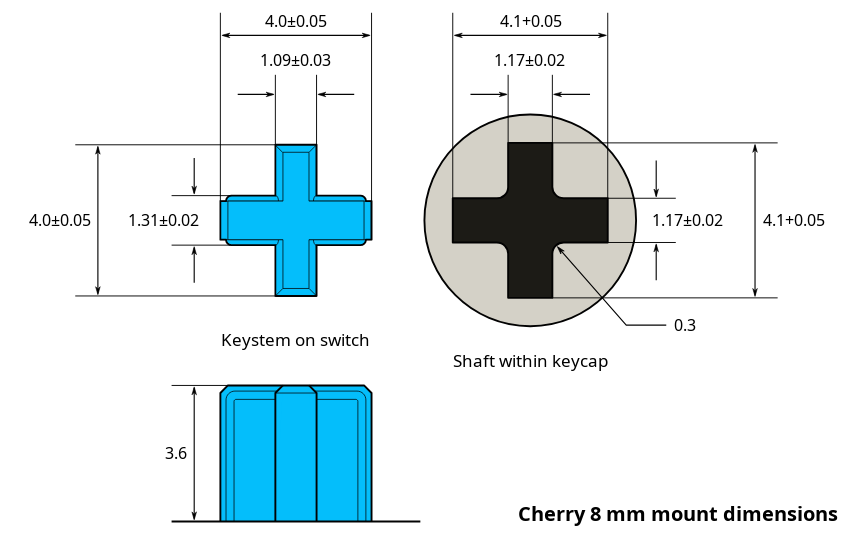

In [3]:
keystem_thickness_adjust = +0.3
keycap_mount_height = 3.6 + 1.0

pillar_size = (5.5, 7.1)
with BuildPart() as keycap_mount:
    with BuildSketch(mode=Mode.PRIVATE) as inner:
        Rectangle(1.17 + keystem_thickness_adjust, 4.1+keystem_thickness_adjust)
        Rectangle(4.1+keystem_thickness_adjust, 1.17 + keystem_thickness_adjust)
        fillet(
            inner.vertices()
            .filter_by_position(Axis.X, -1, 1)
            .filter_by_position(Axis.Y, -1, 1),
            radius=0.3,
        )
    with BuildSketch():
        offset(inner.sketch, amount=0.5)
        add(inner.sketch, mode=Mode.SUBTRACT)
    extrude(amount=-keycap_mount_height)

show(keycap_mount)

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…

In [4]:
key_width = 18
keycap_thickness = 1
with BuildPart() as keycap:
    with BuildSketch() as sk:
        r = RegularPolygon(key_width / math.sqrt(3), 6)
    extrude(amount=keycap_thickness)
    add(keycap_mount.part)
    with BuildSketch(keycap.faces().sort_by(Axis.Z).last):
        RegularPolygon(key_width / math.sqrt(3) - 2, 6)
        RegularPolygon(key_width / math.sqrt(3) - 2 - 0.7, 6, mode=Mode.SUBTRACT)

show(keycap)
export(keycap.part, "keycap")

keycap_vertices = keycap.part.vertices().sort_by(Axis.Z)
keycap_height = keycap_vertices.last.to_vector().Z - keycap_vertices.first.to_vector().Z

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/keycap.step(3422 ents)  Write  Done


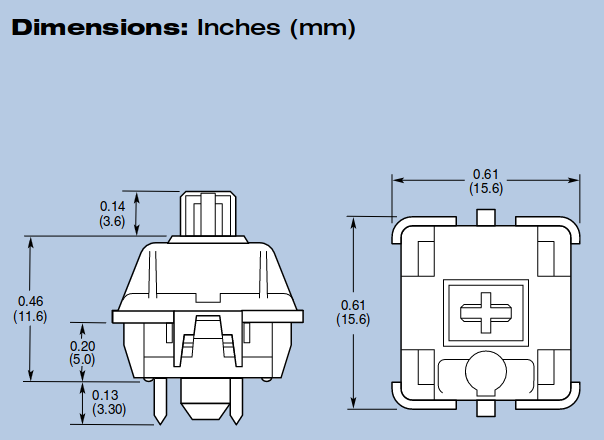
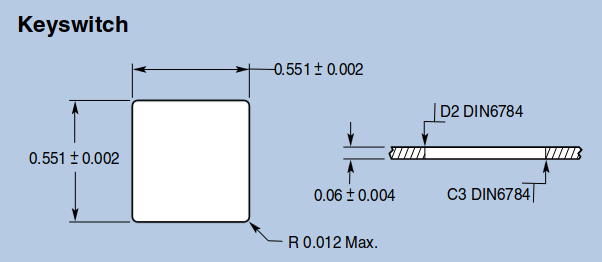

In [5]:
switch_height_bottom_half = 5 + 3.3
switch_height_top_half = 11.6 - 5
switch_width = 14  # 0.551 inch
switch_width_outer = 15.6
switch_plate_thickness = 1.5  # 0.06 in

In [6]:
switch_spacing = 19
switch_vertical_spacing = switch_spacing / math.sqrt(3) / 2 * 3
keycap_spacing = switch_spacing - key_width
skip_columns = 1
column = 9 + skip_columns
row = 15
layout_cutter = [
    row * 0 + 14,
    row * 2 + 14,
    row * 4 + 14,
    row * 6 + 0,
    row * 6 + 1,
    row * 6 + 3,
    row * 6 + 5,
    row * 6 + 8,
    row * 6 + 10,
    row * 6 + 12,
    row * 6 + 13,
    row * 6 + 14,
    row * 7 + 0,
    row * 7 + 1,
    row * 7 + 2,
    row * 7 + 3,
    row * 7 + 4,
    row * 7 + 6,
    row * 7 + 8,
    row * 7 + 10,
    row * 7 + 11,
    row * 7 + 12,
    row * 7 + 13,
    row * 7 + 14,
    row * 8 + 0,
    row * 8 + 1,
    row * 8 + 2,
    row * 8 + 3,
    row * 8 + 4,
    row * 8 + 6,
    row * 8 + 7,
    row * 8 + 9,
    row * 8 + 10,
    row * 8 + 11,
    row * 8 + 12,
    row * 8 + 13,
    row * 8 + 14,
]
hex_y_offset = switch_spacing / 4
hex_x_offset = -switch_vertical_spacing / 2
hex_locations = HexLocations((switch_spacing) / 2, column, row).local_locations
hex_locations = sorted(hex_locations, key=Location.to_tuple)
hex_locations = hex_locations[row * skip_columns :]
for idx in range(0, len(hex_locations)):
    loc = hex_locations[idx] * Location((hex_x_offset, hex_y_offset, 0))
    hex_locations[idx] = loc

key_locations = hex_locations.copy()
for idx in sorted(layout_cutter, reverse=True):
    del key_locations[idx]
print("KEY COUNT:", len(key_locations))

with BuildSketch() as keyboard_base:
    with Locations(*key_locations):
        RegularPolygon((switch_spacing + keycap_spacing) / math.sqrt(3), 6)
keyboard_base_size = keyboard_base.sketch.bounding_box().size

# a helper to help you compare the outer edges
with BuildSketch() as _keycap_edge_helper:
    with Locations(*key_locations):
        RegularPolygon(key_width / math.sqrt(3), 6)
with BuildSketch() as _switch_edge_helper:
    with Locations(*key_locations):
        Rectangle(switch_width_outer, switch_width_outer)
show(
    keyboard_base,
    _keycap_edge_helper,
    _switch_edge_helper,
    Rectangle(*keyboard_base_size),
)

exporter = ExportSVG(unit=Unit.MM)
exporter.add_layer("key")
exporter.add_shape(
    _keycap_edge_helper.sketch.moved(Rotation(0, 0, -90)).faces(), layer="key"
)
exporter.add_layer("switch")
exporter.add_shape(
    _switch_edge_helper.sketch.moved(Rotation(0, 0, -90)).faces(), layer="switch"
)
exporter.write("../images/edges.svg")

KEY COUNT: 98
100% ⋮————————————————————————————————————————————————————————————⋮ (4/4)  0.12s


CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…

In [7]:
body_extend = 10
bottom_thickness = 1
with BuildPart() as keyboard_body:
    with BuildSketch() as sk:
        Rectangle(*keyboard_base_size)
        r = offset(amount=body_extend, kind=Kind.INTERSECTION)
        fillet(r.vertices(), radius=10)
        with Locations(*key_locations):
            Rectangle(switch_width, switch_width, mode=Mode.SUBTRACT)
    extrude(amount=switch_height_bottom_half)
    with BuildSketch(Plane.XY.offset(switch_height_bottom_half-switch_plate_thickness)):
        with Locations(*key_locations):
            Rectangle(switch_width+1*2, 5)
    extrude(amount=-2, mode=Mode.SUBTRACT)
    with BuildSketch():
        Rectangle(*keyboard_base_size)
    extrude(amount=3, mode=Mode.SUBTRACT)

show(keyboard_body)
keyboard_bbox = keyboard_body.part.bounding_box()

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…

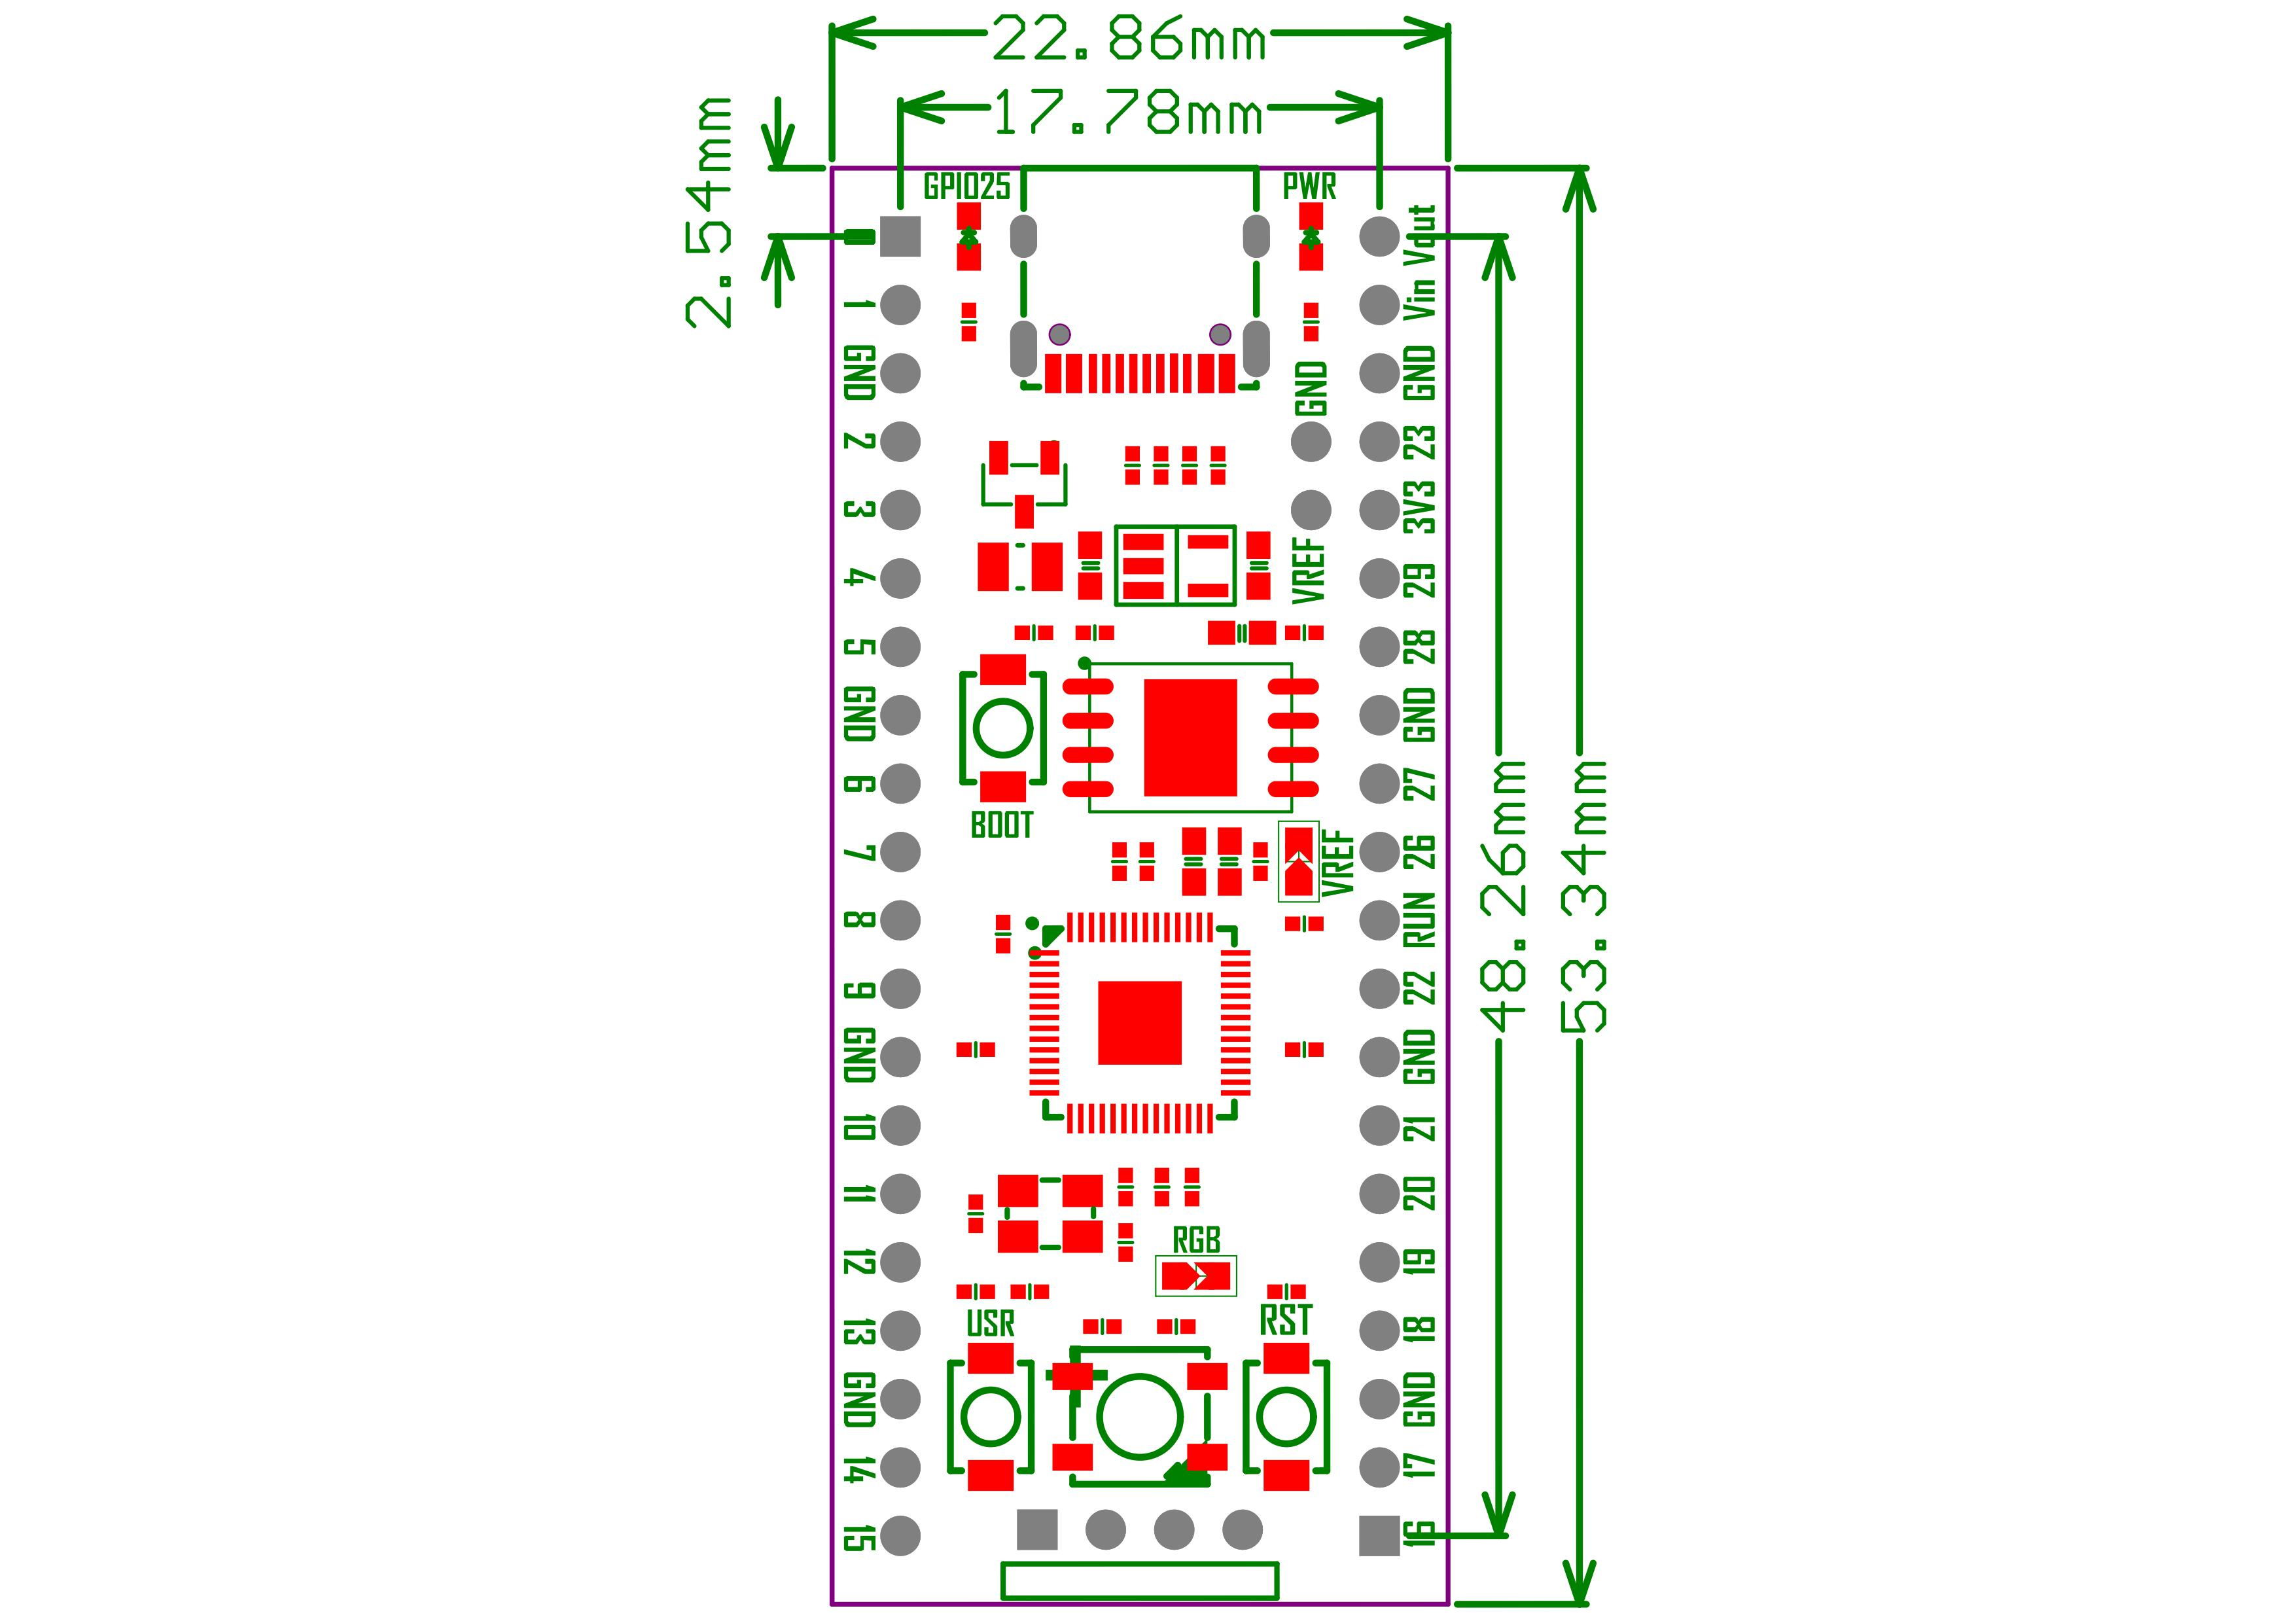

In [8]:
pcb_size = (53.34+0.2, 22.86+0.2, 1.2)
pcb_void_height = pcb_size[2] + 3.3 + 0.1
pcb_y_offset = 1.5
pcb_x_offset = -30
pcb_pos = (keyboard_bbox.max.X + pcb_x_offset, keyboard_bbox.min.Y + pcb_y_offset, 3)

with BuildPart() as pcb_void:
    with BuildSketch():
        Rectangle(pcb_size[0], pcb_size[1], align=(Align.MIN, Align.CENTER))
    extrude(amount=pcb_size[2])
    with BuildSketch():
        Rectangle(pcb_size[0], pcb_size[1] - 1.2 * 2, align=(Align.MIN, Align.CENTER))
    extrude(amount=pcb_size[2] + 1)
    with BuildSketch():
        Rectangle(pcb_size[0], pcb_size[1] - 4 * 2, align=(Align.MIN, Align.CENTER))
    extrude(amount=pcb_void_height+10)
    with BuildSketch(Plane.YZ):
        with Locations((0, pcb_size[2])):
            Rectangle(pcb_size[1] - 4 * 2, 10, align=(Align.CENTER, Align.MIN))
    extrude(amount=-10)
    add(pcb_void.faces().sort_by(Axis.Z).first)
    with BuildSketch(Plane.XY.offset(- 1)) as sk:
        n = 1.5
        with Locations((n, 0)):
            Rectangle(pcb_size[0]-n, pcb_size[1], align=(Align.MIN, Align.CENTER))
    loft()
    add(pcb_void.faces().sort_by(Axis.Z).first)
    extrude(amount=-10)
    with BuildSketch():
        with Locations((pcb_size[0]-7,0,0)):
            RectangleRounded(2, pcb_size[1]-4*2,radius=2/2-0.00001)
    extrude(amount=10)

show(pcb_void)

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…

In [9]:
lid_thickness = 1
lid_margin = 1.5
lid_size = (
    keyboard_base_size.X + (body_extend - lid_margin) * 2,
    keyboard_base_size.Y + (body_extend - lid_margin) * 2,
)
screw_margin = 7.5
screw_pos = [
    (
        keyboard_bbox.min.X + keyboard_bbox.size.X / 2,
        keyboard_bbox.min.Y + screw_margin,
    ),
    (
        keyboard_bbox.min.X + keyboard_bbox.size.X / 2,
        keyboard_bbox.max.Y - screw_margin,
    ),
    (keyboard_bbox.min.X + screw_margin, keyboard_bbox.min.Y + screw_margin),
    (
        keyboard_bbox.min.X + screw_margin,
        keyboard_bbox.min.Y + keyboard_bbox.size.Y / 3 * 1,
    ),
    (
        keyboard_bbox.min.X + screw_margin,
        keyboard_bbox.min.Y + keyboard_bbox.size.Y / 3 * 2,
    ),
    (keyboard_bbox.min.X + screw_margin, keyboard_bbox.max.Y - screw_margin),
    (keyboard_bbox.max.X - screw_margin, keyboard_bbox.min.Y + screw_margin),
    (
        keyboard_bbox.max.X - screw_margin,
        keyboard_bbox.min.Y + keyboard_bbox.size.Y / 3 * 1,
    ),
    (
        keyboard_bbox.max.X - screw_margin,
        keyboard_bbox.min.Y + keyboard_bbox.size.Y / 3 * 2,
    ),
    (keyboard_bbox.max.X - screw_margin, keyboard_bbox.max.Y - screw_margin),
]
screw_h = 4 + 0.5
screw_hole_r = 2.7 / 2
screw_head_r = 6 / 2
screw_head_h = 2
with BuildPart() as keyboard_body_final:
    add(keyboard_body.part)
    bottom_sketch = keyboard_body.part.faces().sort_by(Axis.Z).first.face().outer_wire()
    with BuildSketch() as sk:
        make_face(bottom_sketch.edges())
        make_face(bottom_sketch.offset_2d(-lid_margin).edges(), mode=Mode.SUBTRACT)
    extrude(amount=-lid_thickness)
    with Locations(pcb_pos):
        add(pcb_void.part, rotation=(0, 0, 90), mode=Mode.SUBTRACT)
        with Locations((0, pcb_size[0] + 1 + screw_hole_r)):
            hole = Hole(screw_hole_r, screw_h)
            hole_axis = Axis(
                hole.center(), hole.faces().sort_by(Axis.Z).first.normal_at()
            )
            CylindricalJoint(
                "pcb_screw_hole",
                axis=hole_axis,
                linear_range=(0, 10),
            )
    with Locations(keyboard_body_final.faces().sort_by(Axis.Z).first):
        with Locations(*screw_pos):
            CounterSinkHole(screw_hole_r, screw_head_r, screw_h + screw_head_h)

show(keyboard_body_final)
export(keyboard_body_final.part, "keyboard_body")

100% ⋮————————————————————————————————————————————————————————————⋮ (2/2)  0.73s


CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/keyboard_body.step(96256 ents)  Write  Done


In [34]:
with BuildPart() as cover:
    with BuildSketch():
        make_face(keyboard_body.part.faces().sort_by(Axis.Z).first.face().outer_wire().edges())
        offset(amount=-lid_margin-0.4)
    extrude(amount=lid_thickness)
    with Locations(cover.faces().sort_by(Axis.Z).first):
        with Locations(*screw_pos):
            CounterSinkHole(screw_hole_r, screw_head_r, screw_h+screw_head_h)
show(cover)
export(cover.part, "keygboard_cover")

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/keygboard_cover.step(1510 ents)  Write  Done


In [11]:
with BuildPart() as pcb_cover:
    pcb_lid_base_thickness = switch_height_bottom_half - 3 - pcb_void_height
    pcb_lid_total_thickness = switch_height_bottom_half-3-pcb_size[2]
    with BuildSketch():
        Rectangle(pcb_size[1]-4*2, pcb_size[0], align=(Align.CENTER, Align.MIN))
    extrude(amount = -pcb_lid_base_thickness)
    with BuildSketch(Plane.XY.offset(-pcb_lid_base_thickness)):
        with Locations((0,pcb_size[0])):
            Rectangle(pcb_size[1]-4*2,4, align=(Align.CENTER, Align.MAX))
    extrude(amount=-(pcb_void_height-pcb_size[2]))
    with BuildSketch(Plane.XY.offset(-pcb_lid_base_thickness)):
        with Locations((0,32)):
            Rectangle(pcb_size[1]-4*2,7)
    extrude(amount=-(pcb_void_height-pcb_size[2]-0.95))
    with BuildSketch(Plane.XY.offset(-pcb_lid_base_thickness)):
        with Locations((0,14.7)):
            Rectangle(pcb_size[1]-4*2,3)
    extrude(amount=-(pcb_void_height-pcb_size[2]-1.15))
    with BuildSketch(Plane.XZ):
        Rectangle(pcb_size[1]-4*2, pcb_lid_total_thickness, align=(Align.CENTER, Align.MAX))
        with Locations((0, -pcb_lid_total_thickness)):
            RectangleRounded(9, 3.3,1.3, align=(Align.CENTER, Align.MIN), mode=Mode.SUBTRACT)
    extrude(amount=lid_margin)
        
show(pcb_cover)
export(pcb_cover.part, "pcb_cover")

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/pcb_lid.step(1918 ents)  Write  Done


In [35]:
with BuildPart() as pcb_clamp:
    Cylinder(6, 2, align=(Align.CENTER, Align.CENTER, Align.MAX))
    CounterSinkHole(screw_hole_r, screw_head_r, screw_h + screw_head_h)
    RigidJoint("top", joint_location=Location((0, 0, 0))),
    CylindricalJoint(
        "top",
        axis=Axis((0, 0, 0), (0, 0, 1)),
        linear_range=(0, 10),
    )
    RigidJoint("bottom", joint_location=Location((0, 0, -2))),
show(pcb_clamp)
export(pcb_clamp.part, "pcb_clamp")

100% ⋮————————————————————————————————————————————————————————————⋮ (3/3)  0.04s


CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/pcb_clamp.step(265 ents)  Write  Done


In [32]:
keyboard_body_final.joints["pcb_screw_hole"].connect_to(pcb_clamp.joints["bottom"], position=0)

show(
    keyboard_body_final,
    pcb_clamp.part,
    cover.part.moved(Location((0, 0, -lid_thickness))),
    pcb_cover.part.moved(
        Location((keyboard_bbox.max.X+pcb_x_offset,keyboard_bbox.min.Y+ pcb_y_offset, switch_height_bottom_half))
    ),
    colors=["gray", None, "#FFFFFF", "#000000"],
    render_joints=False,
)

100% ⋮————————————————————————————————————————————————————————————⋮ (4/4)  0.15s


CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…

In [33]:
with BuildPart() as wrist_rest:
    with BuildSketch():
        SlotOverall(
            60, switch_height_bottom_half + switch_height_top_half + keycap_height
        )
    extrude(amount=100)
    chamfer(wrist_rest.edges().filter_by(Axis.Z, reverse=True),length=1)
show(wrist_rest)
export(wrist_rest.part, "wrist_rest")

CadViewerWidget(anchor=None, cad_width=800, glass=True, height=600, pinning=False, theme='browser', title=None…


*******************************************************************
******        Statistics on Transfer (Write)                 ******

*******************************************************************
******        Transfer Mode = 0  I.E.  As Is       ******
******        Transferring Shape, ShapeType = 0                      ******
** WorkSession : Sending all data
 Step File Name : out/wrist_rest.step(790 ents)  Write  Done
